# Combine XGB and GNN
We train with targets from 2021 and validate on targets from 2022.

In this notebook we build a simple GNN model and combine it with XGB model to see if GNN improves XGB

# Simple GNN Baseline

In [1]:
import os
os.environ.setdefault("CUDA_VISIBLE_DEVICES", "7")

VER=8

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv

In [3]:
author_features_2021 = pd.read_parquet(f"data/author_features_v8.pqt")
author_targets_2021 = pd.read_parquet(f"data/author_targets_v8.pqt")

author_features_2022 = pd.read_parquet(f"data/author_features_v2.pqt")
author_targets_2022 = pd.read_parquet(f"data/author_targets_v2.pqt")
print("Author features shape:", author_features_2022.shape )

Author features shape: (143691, 18)


In [4]:
print("Author targets shape:", author_targets_2022.shape )
author_targets_2022.head()

Author targets shape: (143691, 5)


,Author_ID,target,coauthor_ids,coauthor_counts,degree
0,0,0,[],[],0
1,1,0,"[2, 3, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 1, 1]",7
2,2,0,"[1, 3, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 1, 1]",7
3,3,0,"[1, 2, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 1, 1]",7
4,4,1,"[1, 2, 3, 5, 6, 7, 8, 2905, 2819, 2906, 2907, ...","[1, 1, 1, 4, 4, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, ...",38


In [5]:
N_2021 = len(author_features_2021)
id2idx_2021 = pd.Series(np.arange(N_2021), index=author_features_2021["Author_ID"].values)

N_2022 = len(author_features_2022)
id2idx_2022 = pd.Series(np.arange(N_2022), index=author_features_2022["Author_ID"].values)

# Feature Engineer

In [6]:
# LOG TRANSFORM FOR NN
for c in [
    "n_coauthors",
    "total_collaborations",
    "total_papers",
    "total_citations",
    "citations_last_3y",
    "max_citations_single_paper",
]:
    author_features_2021[f"log_{c}"] = np.log1p(author_features_2021[c])
    author_features_2022[f"log_{c}"] = np.log1p(author_features_2022[c])

In [7]:
TARGET = "target"

BASE_FEATURES = [
    # --------------------
    # Collaboration graph
    # --------------------
    "n_coauthors",
    "total_collaborations",
    "avg_collab_strength",
    "max_collab_strength",
    "collab_entropy",

    # --------------------
    # Productivity / recency
    # --------------------
    "total_papers",
    "papers_last_1y",
    "papers_last_3y",
    "days_since_last_paper",

    # --------------------
    # Topic specialization
    # --------------------
    #"top_category",          # categorical-as-ordinal (needs encoding for NN)
    "top_category_frac",
    "category_entropy",

    # --------------------
    # Citation impact
    # --------------------
    "total_citations",
    "avg_citations_per_paper",
    "max_citations_single_paper",
    "citations_last_3y",
]

EXTRA_FEATURES = [
    "log_n_coauthors",
    "log_total_collaborations",
    "log_total_papers",
    "log_total_citations",
    "log_citations_last_3y",
    "log_max_citations_single_paper",
]

FEATURES = [c for c in (BASE_FEATURES + EXTRA_FEATURES) if c in author_features_2021.columns]
print("Using features:", FEATURES)

Using features: ['n_coauthors', 'total_collaborations', 'avg_collab_strength', 'max_collab_strength', 'collab_entropy', 'total_papers', 'papers_last_1y', 'papers_last_3y', 'days_since_last_paper', 'top_category_frac', 'category_entropy', 'total_citations', 'avg_citations_per_paper', 'max_citations_single_paper', 'citations_last_3y', 'log_n_coauthors', 'log_total_collaborations', 'log_total_papers', 'log_total_citations', 'log_citations_last_3y', 'log_max_citations_single_paper']


In [8]:
X_train = author_features_2021[FEATURES].astype(np.float32).values
y_train = author_features_2021[TARGET].astype(np.int64).values

# standardize
X_mean = X_train.mean(axis=0, keepdims=True)
X_std  = X_train.std(axis=0, keepdims=True) + 1e-6
X_train = (X_train - X_mean) / X_std

x_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)

In [9]:
X_valid = author_features_2022[FEATURES].astype(np.float32).values
y_valid = author_features_2022[TARGET].astype(np.int64).values

# standardize
X_valid = (X_valid - X_mean) / X_std

x_valid = torch.tensor(X_valid, dtype=torch.float)
y_valid = torch.tensor(y_valid, dtype=torch.long)

# Build Graph

In [10]:
import numpy as np
import torch
from torch_geometric.data import Data

def build_author_graph(
    *,
    author_targets: pd.DataFrame,
    author_features: pd.DataFrame,
    id2idx: pd.Series,
    x: torch.Tensor,
    y: torch.Tensor,
    name: str = ""
) -> Data:

    # Align coauthor lists to author_features order
    aligned = (
        author_targets
        .set_index("Author_ID")
        .loc[author_features["Author_ID"]]
        .reset_index()
    )

    src_list, dst_list, w_list = [], [], []

    for i, (co_ids, co_cts) in enumerate(
        zip(aligned["coauthor_ids"], aligned["coauthor_counts"])
    ):
        if len(co_ids) == 0:
            continue

        js = id2idx.loc[co_ids].values.astype(np.int64)
        cts = np.asarray(co_cts, dtype=np.float32)

        src_list.append(np.full(len(js), i, dtype=np.int64))
        dst_list.append(js)
        w_list.append(cts)

    src = np.concatenate(src_list) if src_list else np.empty(0, dtype=np.int64)
    dst = np.concatenate(dst_list) if dst_list else np.empty(0, dtype=np.int64)
    w   = np.concatenate(w_list)   if w_list   else np.empty(0, dtype=np.float32)

    edge_index = torch.tensor(
        np.vstack([src, dst]), dtype=torch.long
    )
    edge_weight = torch.tensor(w, dtype=torch.float)

    if name:
        print(f"{name} Num nodes:", x.size(0))
        print(f"{name} Num edges (directed):", edge_index.size(1))

    data = Data(x=x, edge_index=edge_index, y=y)
    data.edge_weight = edge_weight  # optional

    return data

In [11]:
data_2021 = build_author_graph(
    author_targets=author_targets_2021,
    author_features=author_features_2021,
    id2idx=id2idx_2021,
    x=x_train,
    y=y_train,
    name="2021"
)

data_2022 = build_author_graph(
    author_targets=author_targets_2022,
    author_features=author_features_2022,
    id2idx=id2idx_2022,
    x=x_valid,
    y=y_valid,
    name="2022"
)

2021 Num nodes: 143691
2021 Num edges (directed): 8372061
2022 Num nodes: 143691
2022 Num edges (directed): 11182120


In [12]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=128, dropout=0.1):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.lin   = torch.nn.Linear(hidden_dim, 1)
        self.dropout = dropout

    def forward(self, x, edge_index, return_emb=False):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)

        h = self.conv2(h, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)

        if return_emb:
            return h

        out = self.lin(h).squeeze(-1)
        return out

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_2021 = data_2021.to(device)
data_2022 = data_2022.to(device)

EMB_DIM = 128

# Train GNN

In [14]:
def train_2021_validate_2022(
    data_train,
    data_val,
    epochs=300,
    lr=5e-3,
    wd=1e-4,
    patience=30,
):
    model = GraphSAGE(
        in_dim=data_train.x.size(1),
        hidden_dim=EMB_DIM,
        dropout=0.1
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    y_train = data_train.y.float()
    y_val   = data_val.y.float()

    best_loss = float("inf")
    best_epoch = -1
    best_state = None
    best_auc_at_loss = -1.0  # for reporting only

    for epoch in range(1, epochs + 1):
        # -----------------------------
        # TRAIN on 2021 graph
        # -----------------------------
        model.train()
        opt.zero_grad()

        logits = model(data_train.x, data_train.edge_index)

        loss = F.binary_cross_entropy_with_logits(
            logits,
            y_train
        )

        loss.backward()
        opt.step()

        # -----------------------------
        # VALIDATE on 2022 graph
        # -----------------------------
        model.eval()
        with torch.no_grad():
            logits_val = model(data_val.x, data_val.edge_index)

            val_loss = F.binary_cross_entropy_with_logits(
                logits_val,
                y_val
            ).item()

            val_probs = torch.sigmoid(logits_val).cpu().numpy()
            val_true  = y_val.cpu().numpy()
            auc = roc_auc_score(val_true, val_probs)

        # -----------------------------
        # EARLY STOPPING ON LOGLOSS
        # -----------------------------
        if val_loss < best_loss - 1e-4:
            best_loss = val_loss
            best_epoch = epoch
            best_auc_at_loss = auc
            best_state = {
                k: v.detach().cpu().clone()
                for k, v in model.state_dict().items()
            }

        if epoch % 30 == 0 or epoch == 1:
            print(
                f"  epoch {epoch:3d} | "
                f"train loss {loss.item():.4f} | "
                f"val loss {val_loss:.4f} | "
                f"val AUC {auc:.5f} | "
                f"best loss {best_loss:.4f}"
            )

        if epoch - best_epoch >= patience:
            print(
                f"Early stopping at epoch {epoch} "
                f"(best epoch {best_epoch}, "
                f"best val loss {best_loss:.4f}, "
                f"AUC@best {best_auc_at_loss:.5f})"
            )
            break

    # -----------------------------
    # RESTORE BEST-LOSS MODEL
    # -----------------------------
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    model.eval()

    # -----------------------------
    # FINAL VALIDATION OUTPUTS
    # -----------------------------
    with torch.no_grad():
        logits_val = model(data_val.x, data_val.edge_index)
        val_probs = torch.sigmoid(logits_val).cpu().numpy()

        emb = model(
            data_val.x,
            data_val.edge_index,
            return_emb=True
        )
        val_emb = emb.cpu().numpy()

    return best_auc_at_loss, best_state, val_probs, val_emb

In [15]:
best_auc, best_state, val_probs, val_emb = train_2021_validate_2022(
    data_train=data_2021,
    data_val=data_2022,
    epochs=300,
    lr=5e-3,
    wd=1e-4,
    patience=100,
)

print(f"\nBest validation AUC (2022): {best_auc:.5f}")

  epoch   1 | train loss 0.6920 | val loss 0.8278 | val AUC 0.57891 | best loss 0.8278
  epoch  30 | train loss 0.6060 | val loss 0.6348 | val AUC 0.71083 | best loss 0.6274
  epoch  60 | train loss 0.6028 | val loss 0.6187 | val AUC 0.72885 | best loss 0.6153
  epoch  90 | train loss 0.6014 | val loss 0.6268 | val AUC 0.72554 | best loss 0.6153
  epoch 120 | train loss 0.6007 | val loss 0.6303 | val AUC 0.72616 | best loss 0.6153
Early stopping at epoch 147 (best epoch 47, best val loss 0.6153, AUC@best 0.72954)

Best validation AUC (2022): 0.72954


In [16]:
print("\n==============================")
print("GNN VAL AUC  :", float(roc_auc_score(data_2022.y.cpu().numpy(), val_probs)))
print("==============================")


GNN VAL AUC  : 0.7295371836362609


In [17]:
# SAVE GNN OOF
np.save(f"data/oof_preds_gnn_v{VER}",val_probs)

# Train XGB w/ GNN Embeddings
We will now train XGB using GNN embeddings.

In [18]:
import xgboost as xgb
print(f"XGB version: {xgb.__version__}")

XGB version: 3.1.2


In [19]:
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.005,
    "max_depth": 6,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "tree_method": "hist",
    "n_estimators": 10_000,
    "random_state": 42,
    "early_stopping_rounds": 250,
    "device": "cuda",
}

In [20]:
from cuml.decomposition import PCA
from scipy.stats import rankdata

# -----------------------------
# TABULAR FEATURES
# -----------------------------
X_train_tab = author_features_2021[FEATURES].values.astype(np.float32)
X_val_tab   = author_features_2022[FEATURES].values.astype(np.float32)

y_train = author_features_2021[TARGET].values.astype(np.int64)
y_val   = author_features_2022[TARGET].values.astype(np.int64)

# -----------------------------
# REBUILD GNN + LOAD BEST STATE
# -----------------------------
gnn = GraphSAGE(
    in_dim=data_2021.x.size(1),
    hidden_dim=EMB_DIM,
    dropout=0.1
).to(device)

gnn.load_state_dict({k: v.to(device) for k, v in best_state.items()})
gnn.eval()

# -----------------------------
# EXTRACT EMBEDDINGS
# -----------------------------
with torch.no_grad():
    emb_train = gnn(
        data_2021.x,
        data_2021.edge_index,
        return_emb=True
    ).cpu().numpy().astype(np.float32)

    emb_val = gnn(
        data_2022.x,
        data_2022.edge_index,
        return_emb=True
    ).cpu().numpy().astype(np.float32)

with torch.no_grad():
    logit_train = gnn(data_2021.x, data_2021.edge_index).cpu().numpy()
    logit_val   = gnn(data_2022.x, data_2022.edge_index).cpu().numpy()

# -----------------------------
# PCA (FIT = TRAIN ONLY)
# -----------------------------
PCA_DIM = 8
pca = PCA(n_components=PCA_DIM)
emb_train_pca = pca.fit_transform(emb_train)
emb_val_pca   = pca.transform(emb_val)

# -----------------------------
# BUILD STACKED FEATURES
# -----------------------------
X_train = np.hstack([
    X_train_tab,
    emb_train_pca,
    #logit_train[:, None],
])

X_val = np.hstack([
    X_val_tab,
    emb_val_pca,
    #logit_val[:, None],
])

# -----------------------------
# TRAIN XGB
# -----------------------------
model = xgb.XGBClassifier(**xgb_params)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=100,
)

# -----------------------------
# VALIDATION PREDICTIONS
# -----------------------------
val_preds = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, val_preds)
print(f"\nValidation AUC (2022): {auc:.5f}")

[0]	validation_0-auc:0.72237
[100]	validation_0-auc:0.72968
[200]	validation_0-auc:0.72977
[284]	validation_0-auc:0.72995

Validation AUC (2022): 0.73102


/raid/cdeotte/miniconda3/envs/rapids-torch-2/lib/python3.11/site-packages/xgboost/core.py:750: UserWarning: [15:04:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764168035494/work/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [21]:
# SAVE GNN OOF
np.save(f"data/oof_preds_xgb_gnn_v{VER}",val_preds)

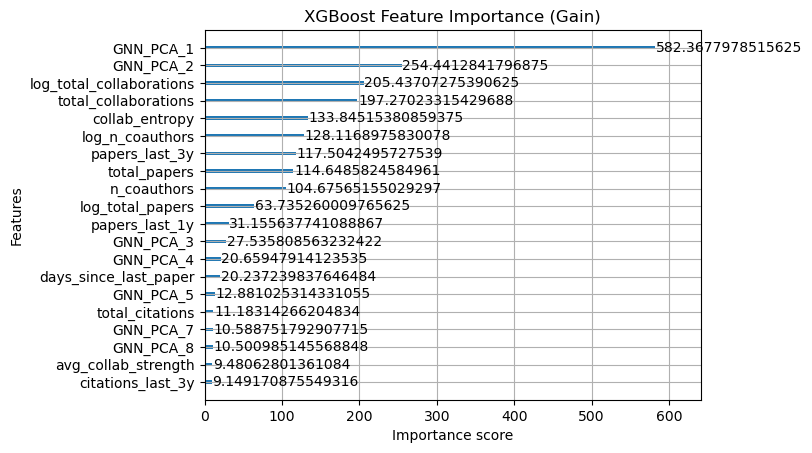

In [22]:
feature_names = FEATURES + [f"GNN_PCA_{k}" for k in range(1,PCA_DIM+1)] #+ ['GNN_pred']
booster = model.get_booster()
booster.feature_names = feature_names

xgb.plot_importance(
    model,
    importance_type="gain",
    max_num_features=20,
)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

# Combine XGB and GNN - Summary

In [23]:
oof_xgb = np.load(f"data/oof_preds_xgb_v{VER}.npy")
oof_gnn = np.load(f"data/oof_preds_gnn_v{VER}.npy")

y_true = author_features_2022[TARGET].values
best_w, best_auc = None, -np.inf
for w in np.arange(0.0, 1.0001, 0.05):
    blend = w * oof_xgb + (1 - w) * oof_gnn
    auc = roc_auc_score(y_true, blend)
    if auc > best_auc:
        best_auc = auc
        best_w = w
print(f"Best ensemble is {best_w:.2f} * XGB + {(1-best_w):.2f} * GNN")

Best ensemble is 0.40 * XGB + 0.60 * GNN


In [24]:
print("XGB OOF AUC  :", float(roc_auc_score(author_features_2022[TARGET].values, oof_xgb)))
print("GNN OOF AUC  :", float(roc_auc_score(author_features_2022[TARGET].values, oof_gnn)))
print()

blend = best_w*oof_xgb + (1-best_w)*oof_gnn
print(f"BLEND OOF AUC   :", float(roc_auc_score(author_features_2022[TARGET].values, blend)))

oof_xgb_gnn = np.load(f"data/oof_preds_xgb_gnn_v{VER}.npy")
print("XGB w/ GNN emb  :", float(roc_auc_score(author_features_2022[TARGET].values, oof_xgb_gnn)))

XGB OOF AUC  : 0.7273856059900606
GNN OOF AUC  : 0.7295371836362609

BLEND OOF AUC   : 0.7319818471952111
XGB w/ GNN emb  : 0.7310208699041055
